In [193]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np
from read_data import *
from filter import *
from analysis import *
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import os
cwd = os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model classes

## Epoch

In [ ]:
class Episode(object):    
    def __init__(self, names, time, currentTrace, nthEp = 0, piezo = None, commandVoltage = None, filter = None, fc = None):
        """
        Episode objects hold all the information about an epoch and should be used to store raw and manipulated data
        
        Parameters:
            time [1D array of floats] - containing time (in seconds)
            currentTrace [1D array of floats] - containing the current trace
            piezo [1D array of floats] - the voltage applied to the Piezo device
            commandVoltage [1D array of floats] - voltage applied to cell
            nthEp [int] - the number of measurements on this cell that came 
                            before this one
            filter [string] - type of filter used
            fc [int] - cutoff frequency of the filter in Hz
        """
        self.time = time*1000 #convert from seconds to milliseconds
        self.currentTrace = currentTrace
        self.piezo = piezo
        self.commandVoltage = commandVoltage
        self.nthEp = int(nthEp)
        self.names = names
        self.filterMethod = filter
        self.cutoffFrequency = int(fc)
        self.baselineCorrected = False
        self.idealized = 'Note idealized'
    def plot_trace(self):
        fig = plt.figure(figsize = (20,5))
        plt.plot(self.time,self.currentTrace)
        plt.xlabel('time [ms]')
        plt.ylabel(self.names[0])
#         plt.show()#not needed with matplotlib inline
    def plot_episode(self, mode='full'):
        if mode == 'full':
            n = 3
            toPlot = [self.currentTrace, self.piezo, self.commandVoltage]
        elif mode == 'current':
            print("This does not work yet!")
#             n = 1
#             toPlot = [self.currentTrace]
            pass
        fig, ax = plt.subplots(n,1,figsize=(20,10),sharex=True)
        fig.suptitle('episode #%.d'%(self.nthEp+1))
        end = np.min([len(self.currentTrace),len(self.time)])
        for i in range(n):
            ax[i].plot(self.time[:end],toPlot[i][:end])
            ax[i].set_ylabel(self.names[i])
        plt.setp(ax,xlabel='time [ms]')
#         plt.show() #not needed with matplotlib inline

## Recording

In [3]:
class Recording(object):
    """
    Recording objects contain all the information and data of a single patch recording as well as the the processed data.
    
    parameters:
    filename [string] - name of the file containing the data
    filepath [string] - path containing the data file
    samplingrate [int] - sampling rate of the recording (samples/second)
    filetype [string] - specify which kind of file is being loaded, takes 'axo' for axograph files and 'bin' for binary files
    headerlength [int] - in case of binary files with a header preceeding the data in the file
    bindtype [numpy type] - in case of binary the data type, should be somemthing like 'np.int16'
    
    Recording objects load the data into Episode objects which can later be filtered or manipulated in other ways. Presently after each manipulation the newly
    processed data as well as the original data are stored.
    """
    def __init__(self, 
                 filename='170404 015.axgd',
                 filepath=cwd+'/data',
                 samplingrate=4e4,
                 filetype = 'axo',
                 headerlength = None,
                 bindtype = None,
                 *args,**kwargs):
        
        self.filename = filename
        self.path = filepath
        self.samplingRate = int(samplingrate)
        self.filetype = filetype
        self.headerlength = headerlength
        self.bindtype = bindtype

        self.data = {'raw':[]}
        ### The raw data and all the result of any manipulations will be stored in this dictionary with a key determined by the operations

        #self.load_data()
        
        
#     def lookup_deco(f):
#         def do_lookup(dataKey, *args, **kwargs):
#             try:
#                 data = self.data[dataKey]
#             except KeyError:
#                 print("The data you're looking for does not exist")
#             f(data, *args, **kwargs)
#         return do_lookup(dataKey, *args, **kwargs)
        
    def load_data(self):
        """Load the raw data from binary of axograph file. All parameters are specified in the initialization of th Recording instance."""
        if self.filetype == 'axo':
            names, time, current, piezo, voltage = load_axo(self.path, self.filename)   
            self.data['raw'] = self.store_rawdata(names, time, current, piezo=piezo, commandVoltage = voltage)
        elif self.filetype == 'bin':
            names, time, current = load_binary(self.path, self.filename,self.bindtype,self.headerlength,self.samplingRate)
            self.data['raw'] = self.store_rawdata(names, time, current[np.newaxis])
        else:
            print("Filetype not supported.")
            
    def store_rawdata(self, names, time, current, piezo = None, commandVoltage = None):
        """
        Store the raw data in epoch objects
        """
        rawData = []
        for i in range(len(current)):
            if piezo is not None:
                epo = Epoch(names, time, current[i], nthEpoch=i, piezo=piezo[i], commandVoltage=commandVoltage[i])
            else:
                epo = Epoch(names, time, current[i], nthEpoch=i)
            rawData.append(epo)
        return rawData
            
    def filter_data(self, fc = 1e3, filter = 'Gaussian'):
        if filter == 'Gaussian':
            name = "G"
            fcs = fc/self.samplingRate #cutoff frequency in 1/samples
            filterWindow = Gaussian(fcs)
            filter_lag = 0 #int(1/(2*fcs))
            fData = []
            for epoch in self.data['raw']:
                filteredTrace = apply_filter(epoch.currentTrace, filterWindow)
                filteredEpoch = copy.deepcopy(epoch)
                filteredEpoch.currentTrace = filteredTrace[filter_lag:] 
                filteredEpoch.filterMethod = 'Gaussian'
                filteredEpoch.cutoffFrequency = fc
                fData.append(filteredEpoch)
            name = name+str(int(fc))+'Hz'
            self.data[name] = fData
            
    def baseline_correction(self, dataKey, interval, method='simple'):
        """
        Do baseline correction on each epoch.
        Parameters:
            interval - list containing the beginning and end points of the interval from the baseline is to be estimated (in milliseconds)
            dataKey - string that contains the dictionary key of the data
        """
        try: ###should write a decorator that does this
            data = self.data[dataKey]
        except KeyError:
            print("These data don't exist.")
            pass
        if "_BC" in dataKey:
            print("Baseline correction has already been performed on these data.")
            pass
        corrected = []
        for epoch in data:
            correctedEpoch = copy.deepcopy(epoch)
            correctedEpoch.currentTrace = baseline(epoch.currentTrace, interval, self.samplingRate)
            correctedEpoch.baselineCorrected = True
            corrected.append(correctedEpoch)
        name = dataKey+"_BC"
        self.data[name] = corrected
    
    def idealization(self, dataKey, threshold = .5):
        if self.filetype is not 'bin':
            print("Can only idealize single level channels so far. (That means bin files)")
            pass
        try:
            data = self.data[dataKey]
        except KeyError:
            print("These data don't exist.")
            pass
        idealized = []
        for epoch in data:
            idealizedEpoch = copy.deepcopy(epoch)
            activity, signalmax = threshold_crossing(idealizedEpoch.currentTrace,threshold)
            idealizedEpoch.currentTrace = activity*signalmax
            idealizedEpoch.idealized = 'Idealized with simple threshold crossing'
            idealized.append(idealizedEpoch)
        name = dataKey + '_TC'
        self.data[name] = idealized

## Initialization of model and application of methods

In [ ]:
rec = Recording()
rec.load_data()

In [ ]:
rec.filter_data()
rec.baseline_correction('G1000Hz',[0,10])
rec.baseline_correction('raw',[0,10])

In [ ]:
original = rec.data['raw_BC'][0].currentTrace[10:-50]
signal = rec.data['G1000Hz_BC'][0].currentTrace[10:-50]
time = rec.data['G1000Hz_BC'][0].time[10:-50]

# Functions

## Threshold crossing (multilevel)

In [337]:
def multilevel_threshold(signal,thetas):
    """
    Idealizes a current trace using a threshold crossing algorithm.
    
    Parameters:
        signal [1D array of floats] - the signal to be idealized
        thetas [1D array of floats] - the thresholds seperating the different levels
        
    Returns:
        idealization [1D array of floats] - an array of the same length as `signal` containing the idealization of the trace
        signalmax [float] - the maximum amplitude of the signal
    This method assumes that there are four different conductance states and that their amplitudes are evenly spaced.
    """
    thetas = np.sort(thetas)
    signalmax = np.max(np.abs(signal))
    idealization = np.zeros(len(signal))
    for i in range(len(signal)):
        if thetas[0]<np.abs(signal[i])<thetas[1]:
            idealization[i] = 1/3
        elif thetas[1]<np.abs(signal[i])<thetas[2]:
            idealization[i] = 2/3
        elif thetas[2]<np.abs(signal[i]):
            idealization[i] = 1
    return idealization, signalmax

### Demonstration of idealization by thresholdcrossing

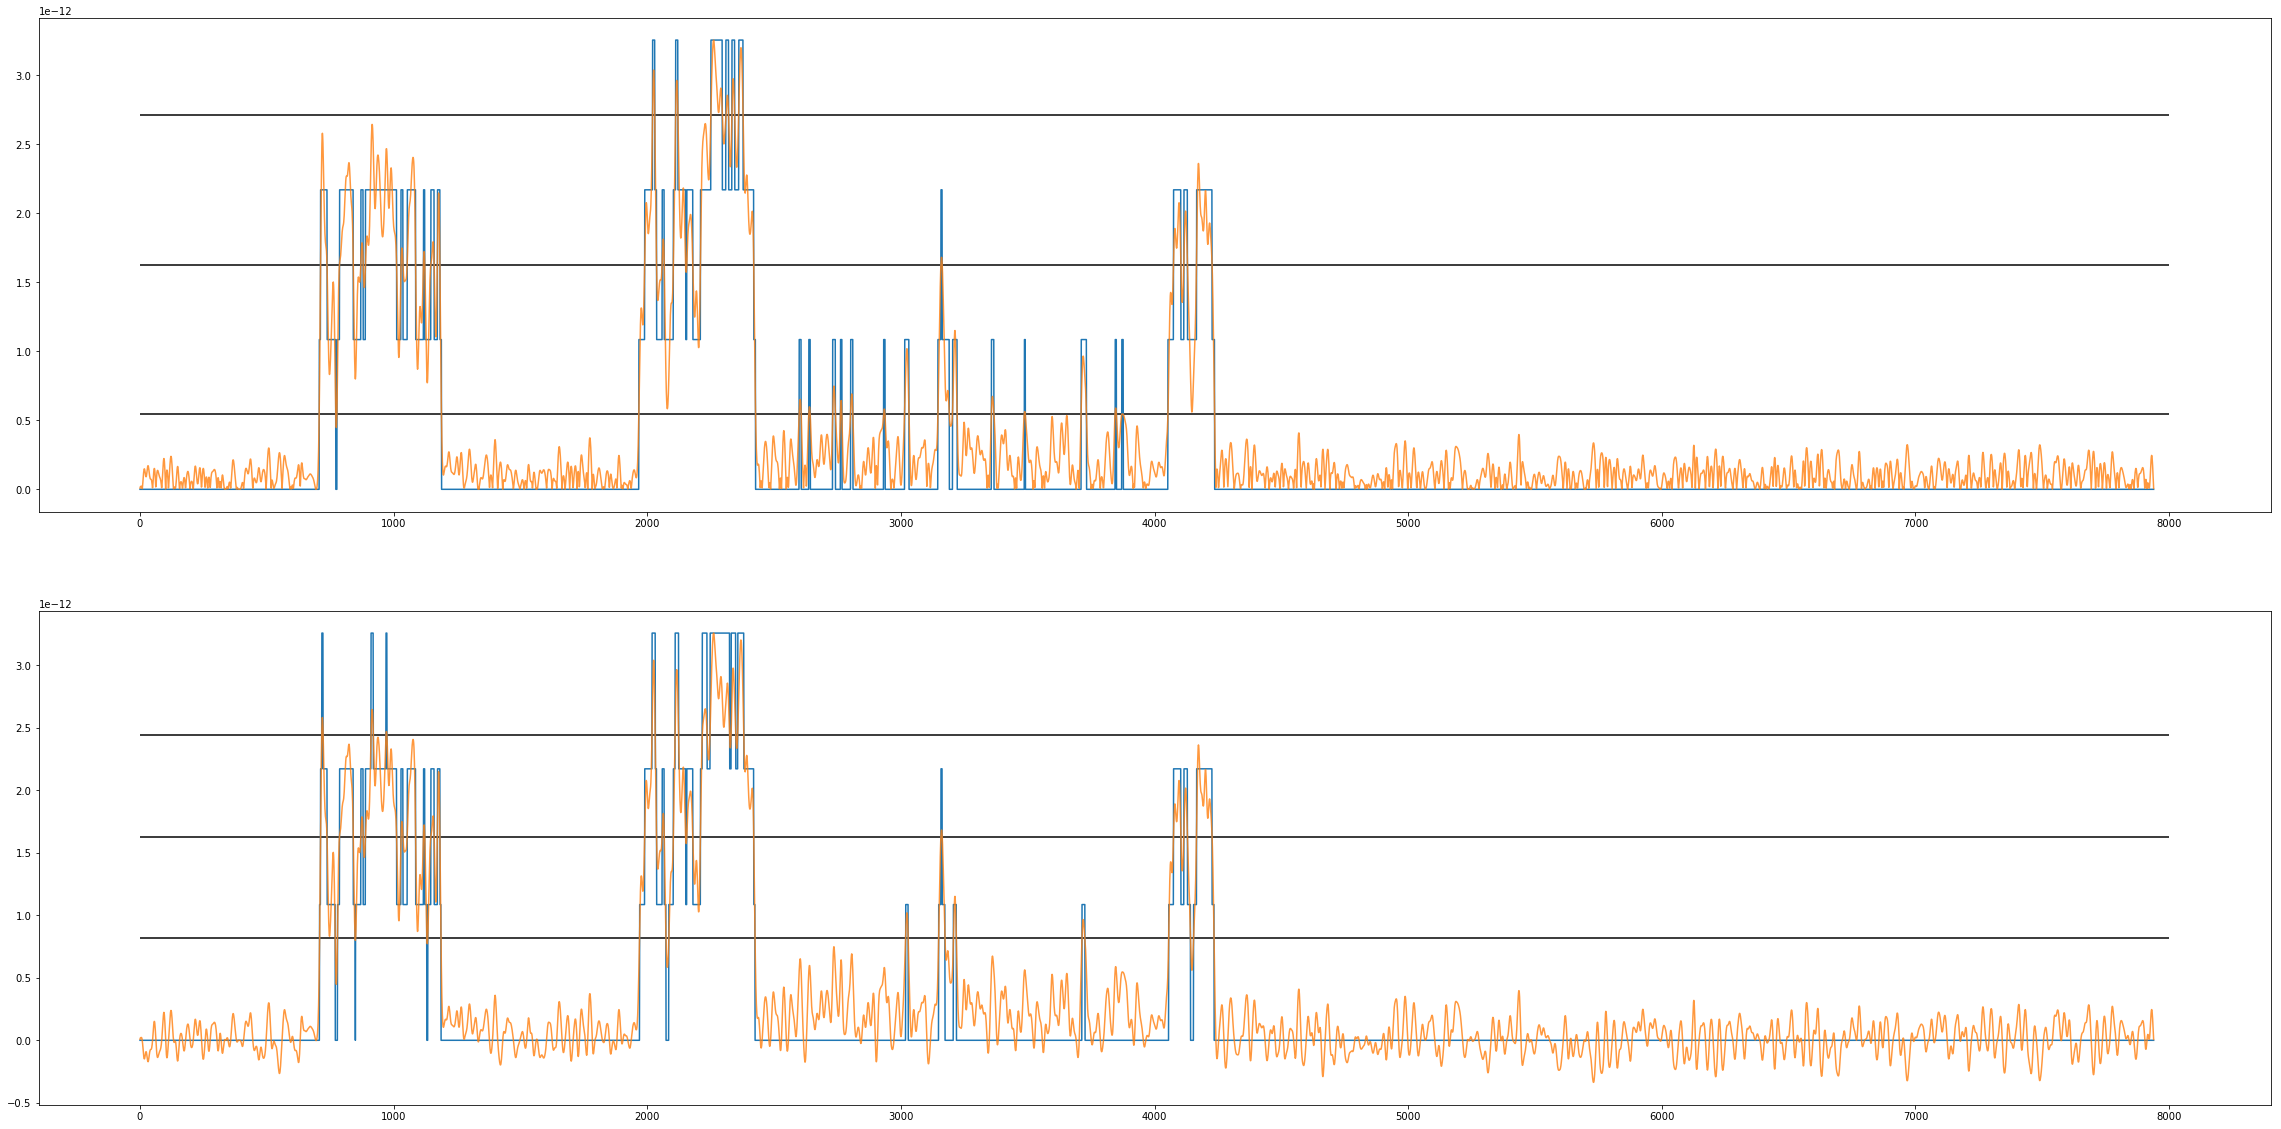

In [48]:
#threshold are halfway between the different levels
thetas = np.array([1/6,1/2,5/6])*np.max(np.abs(signal))
ideal, sm = multilevel_threshold(signal,thetas)
plt.figure(figsize=(40,20))
plt.subplot(211)
plt.plot(ideal*sm,alpha = 1)
plt.plot(np.abs(signal),alpha=.8)
for t in thetas:
    plt.hlines(t,0,8e3)
    
#thresholds are linearly spaced starting at 0, this is not how they are meant to be but looks quite good so it'll stay here for a bit
thetas = np.linspace(0,1,5)[1:-1]*np.max(np.abs(signal))
ideal, sm = multilevel_threshold(signal,thetas)
plt.subplot(212)
plt.plot(ideal*sm,alpha = 1)
plt.plot(-signal,alpha=.8)
for t in thetas:
    plt.hlines(t,0,8e3)

## Generate noise function

In [221]:
def gen_noise(noise_sd, f_0=300, N = 1e4, type='f'):
    """
    generate noise as in Clements and Bekkers '97
        
    parameters:
        noise_sd [float] - desired standard deviation in the noise 
        f_val [float] - the frequeny below which the noise is approximately white 
        N [int] - desired length of the array 
        type [string] = the type of noise that is to be generated, can be 1+1/f ('f') or 1+1/f^2 ('fsqaured')
    returns:
        noise - 1D array of length N containing the the noise signal
    """
    N = int(N)
    f = np.arange(1,N+1)
    
    ## ??
    freq_scale = 4e4/N
    f = f * freq_scale    

    realSpectrum = np.random.uniform(-1,1,size=N) #random array for real part
    imgSpectrum = np.random.uniform(-1,1,size=N) #random array for imaginary part
    
    if type == 'f':
        realSpectrum = realSpectrum*(1+f/f_0)
        imgSpectrum = imgSpectrum*(1+f/f_0)
    elif type == 'fsquared':
        realSpectrum = realSpectrum*(1+(f/f_0)**2)
        imgSpectrum = imgSpectrumi*(1+(f/f_0)**2)
    else:
        print('Unkown noise spectrum type. Generating white noise')
        
    spectrum = realSpectrum+1j*imgSpectrum
    power = np.abs(spectrum)**2
    spectrum /= np.sqrt(np.sum(power)) #normalize the power of the spectrum
#     plt.plot(power)
    noise = noise_sd*np.fft.irfft(spectrum,N)*N
    ## np.fft.irfft normalizes with 1/N, according to the paper we want noise_std/sqrt(N*Pi) (not sure what normalization their algorithm uses if any)
    ## so we should multiply with N^(1/2) but it works with N (i.e. it generates noise with a standard deviation that 
    ## is the same order of magnitude as the real noise), also if we want the std to be noise_std we should not multiply by pi^(1/2), probably also related
    ## to the normalization in the algorithm that Clements and Bekkers use
    ## using the real fft because there are no negative frequency components in this noise
    return noise

### Add noise to idealization to reconstruct signal

In [200]:
## get the standard deviation from the filtered and unfiltered signal
std = np.zeros(4)
std_original = np.zeros(4)
for i in range(4):
    mask = ideal == i/3 #creates makes to seperate the different activations found during the idealization
    std[i] = np.std(signal[mask])
    std_original[i] = np.std(original[mask])
print(std)
print(std_original)

[  1.54894708e-13   3.45859523e-13   2.83014387e-13   1.50987510e-13]
[  1.37321915e-12   1.62259185e-12   1.67230478e-12   1.69138653e-12]


it is assumed that noise level is independent of the channel state, the numbers above suggest that this might be true for the open states but that the closed state has a lower level of noise

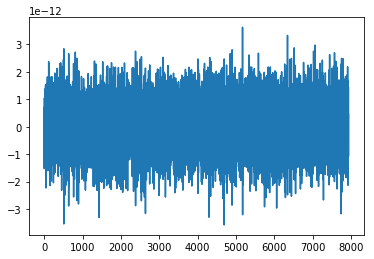

In [213]:
noise = gen_noise(std_original.mean(), N=len(ideal), f_0=1e3)
plt.plot(noise);

In [214]:
thetas = np.array([1/6,1/2,5/6])*np.max(np.abs(signal))
ideal, sm = multilevel_threshold(signal,thetas)

reconstructed = -sm*ideal+noise

#create standard gaussian filter
fc, fs, = 1e3, 4e4
fcs = fc/fs
window = Gaussian(fcs)

filtered = apply_filter(reconstructed,window)

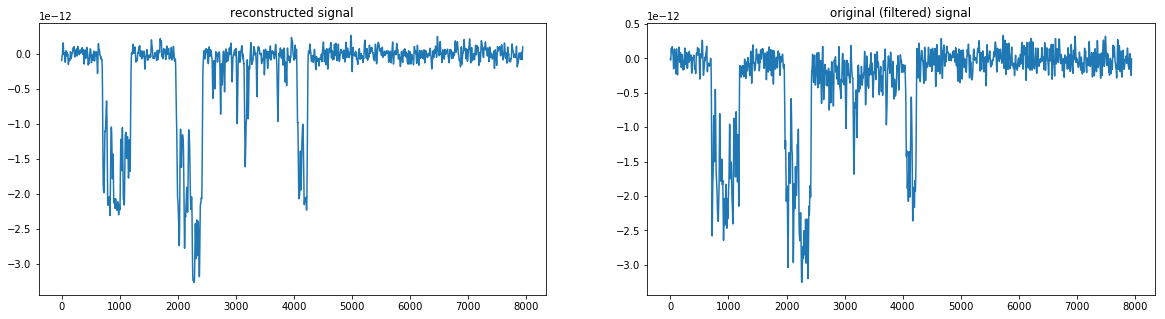

In [215]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(filtered)
plt.title('reconstructed signal')
plt.subplot(122)
plt.plot(signal)
plt.title('original (filtered) signal');

#### Comparison with Andrew's noise simulator

Below is a comparison of the noise generated above and the noise generated with Andrew's function. In order to make this work I had to add a length parameter to the `numpy.fft.irfft` function in `noise_gen.spec_to_noise` as the length would otherwise be $2N-2$ (this is due to something weird in the ifft function and is not what the documentation says should happen).

Scaling....
[  8.51928436e-05-0.00022668j   4.21662588e-04-0.00036166j
  -3.22444120e-04+0.00033752j ...,   2.33797644e-02-0.00786897j
  -1.41504398e-02-0.01296443j  -1.37014017e-02+0.01841776j] 7940


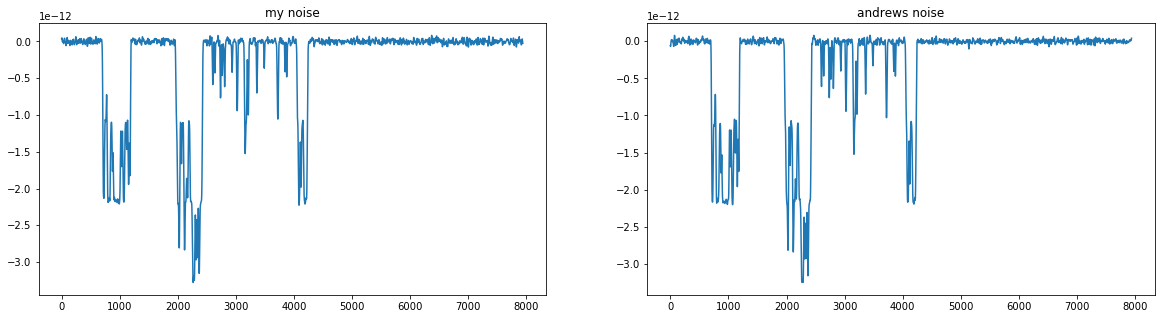

In [232]:
import noise_gen
noise = gen_noise(std_original.mean(), N=len(ideal),f_0 = 1000)
reconstructed = -sm*ideal+noise
filtered = apply_filter(reconstructed,window)
f1, s1 = noise_gen.oneplusf_gen(len(signal), type='1+f');
an = noise_gen.spec_to_noise(s1,1.6e-12);
r = -sm*ideal+an
f = apply_filter(r,window)
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(filtered)
plt.title('my noise')
plt.subplot(122)
plt.plot(f)
plt.title('andrews noise');

In [234]:
print('standard deviation:', np.std(noise), np.std(an))

standard deviation: 8.25250635349e-13 8.2178690916e-13


# Gradient descent curve fitting??

In [369]:
def eval_numerical_gradient(f, x):
    fx = f(x) # evaluate function value at original point
    grad = np.zeros(x.shape)
    h = 0.00000001
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        old_value = x[ix]
        x[ix] = old_value + h # increment by h
        fxh = f(x) # evalute f(x + h)
        x[ix] = old_value # restore to previous value (very important!)
        grad[ix] = (fxh - fx) / h # the slope
        it.iternext() # step to next dimension
    return grad

In [370]:
def loss(signal,thetas):
    ideal, sm = multilevel_threshold(signal,thetas)
    difference = np.sum((-sm*ideal-signal)**2)/np.max(np.abs(signal))**2
    return difference

In [373]:
loss(signal,oT)

6756.0203622145682

In [374]:
from functools import partial
loss_train = partial(loss, signal)

In [437]:
oT = np.random.uniform(0,1*np.max(np.abs(signal)),size=3)
oT = np.sort(oT)
# oT = np.array([1/6,1/2,5/6])*np.max(np.abs(signal))
dE = 1
eta = 5e-25
l_old = loss_train(oT)
# print(l_old)
i = 0
while dE>1e-10:
#     print('step ',i)
    i+=1
    df = eval_numerical_gradient(loss_train, oT)
#     print('df',df)
    oT-= eta*df
#     print('thetas:', thetas)
    l_new = loss_train(oT)
#     print(l_new)
    dE = np.abs(l_new-l_old)/l_new
#     print(dE)
    l_old = l_new
    eta*=.9
#     print('current dE%.2d'%dE)
print('finished after %.d steps' %i)

finished after 38 steps


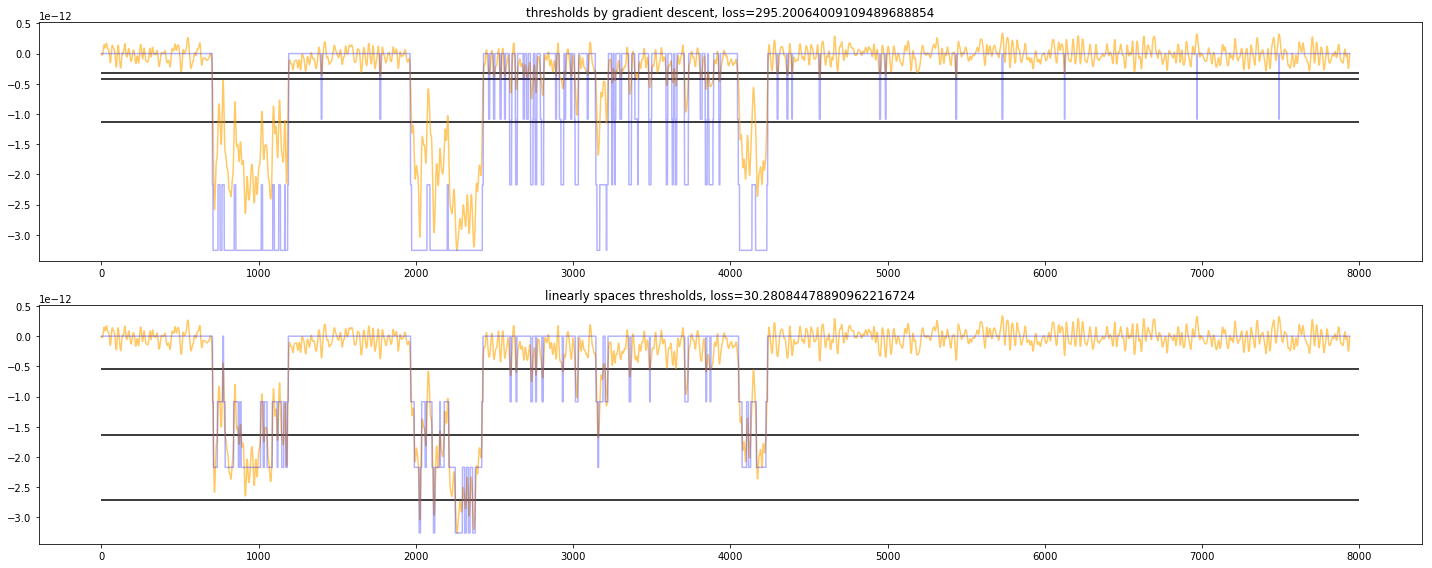

In [438]:
plt.figure(figsize=(20,8))
ideal, sm = multilevel_threshold(signal,oT)
plt.subplot(211)
plt.plot(signal,alpha=.6,c='orange')
plt.plot(-ideal*sm,alpha=.3,c='b')
plt.title('thresholds by gradient descent, loss=%.20f'%loss_train(oT))
for t in oT:
    plt.hlines(-t,0,8e3)

plt.subplot(212)
thetas = np.array([1/6,1/2,5/6])*np.max(np.abs(signal))
ideal, sm = multilevel_threshold(signal,thetas)
plt.plot(signal,alpha=.6,c='orange')
plt.plot(-ideal*sm,alpha=.3,c='b')
plt.title('linearly spaces thresholds, loss=%.20f'%loss_train(thetas))
plt.tight_layout()
for t in thetas:
    plt.hlines(-t,0,8e3)

In [420]:
##save some good thetas from optimization
goodthetas.append(oT)

In [61]:
thetas, t, np.linspace(0,1,5)[:-1]*np.max(np.abs(signal))

(array([  5.42682100e-13,   1.62804630e-12,   2.71341050e-12]),
 array([  5.42682100e-13,   1.62804630e-12,   2.71341050e-12]),
 array([  0.00000000e+00,   8.14023150e-13,   1.62804630e-12,
          2.44206945e-12]))

In [22]:
t = np.array([1/6,1/2,5/6])*np.max(np.abs(signal))

# With simulated data

In [225]:
bn = 'sim1600.bin'
bp = cwd+'/data'
bt = np.int16
bh = 3072
n, t, d = load_binary(bp,bn,bt,bh,4e4)

FileNotFoundError: [Errno 2] No such file or directory: 'sim1600.bin'

In [228]:
rec = Recording(filename=bn,filepath=bp,filetype='bin',headerlength=bh,bindtype=bt)
rec.load_data()

FileNotFoundError: [Errno 2] No such file or directory: 'sim1600.bin'

In [130]:
def visual_compare(recording, dataKey = 'raw', epochnumber = 0, tstart = 0, tend = 5000):
    """
    This function generates a plot comparing the idealized trace to the original trace
    """
    fig = plt.figure(figsize=(20,8))
    time = recording.data[dataKey][epochnumber].time[tstart:tend]
    signal = recording.data[dataKey][epochnumber].currentTrace[tstart:tend]
    ideal = recording.data[dataKey+'_TC'][epochnumber].currentTrace[tstart:tend]
    plt.plot(time, signal, label='unfiltered data',alpha=.8)
    plt.plot(time, ideal, label='idealization', alpha =.7)
    plt.xlabel('time [ms]')
    plt.xticks(np.arange(tstart,tend))
    plt.ylabel('current [A]')
    plt.show()